# Experiment 3: Pandas Dataframes as data structures for Graphs

[//]: # (------------------------------------------    DO NOT MODIFY THIS    ------------------------------------------)
<style type="text/css">
.tg  {border-collapse:collapse;
      border-spacing:0;
     }
.tg td{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg th{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       font-weight:normal;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg .tg-fymr{border-color:inherit;
             font-weight:bold;
             text-align:left;
             vertical-align:top
            }
.tg .tg-0pky{border-color:inherit;
             text-align:left;
             vertical-align:top
            }
[//]: # (--------------------------------------------------------------------------------------------------------------)

[//]: # (-------------------------------------    FILL THIS OUT WITH YOUR DATA    -------------------------------------)
</style>
<table class="tg">
    <tbody>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Title:</td>
        <td class="tg-0pky">Experiment 3: Pandas Dataframes as data structures for Graphs</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Authors:</td>
        <td class="tg-0pky">
            <a href="https://github.com/ecarrenolozano" target="_blank" rel="noopener noreferrer">Edwin Carreño</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Affiliations:</td>
        <td class="tg-0pky">
            <a href="https://www.ssc.uni-heidelberg.de/en" target="_blank" rel="noopener noreferrer">Scientific Software Center</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Date Created:</td>
        <td class="tg-0pky">30.10.2024</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Description:</td>
        <td class="tg-0pky">Creation of a graph using Pandas dataframes and data from CSV files. Conversion to NetworkX is tested too.</td>
      </tr>
    </tbody>
</table>

[//]: # (--------------------------------------------------------------------------------------------------------------)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this notebook we are going to:

1. Import CSV data from nodes and edges.
2. Describe the data from CSVs.
3. Create a data pipeline that:
   - load csv data as Pandas dataframes.
4. Create a NetworkX graph from a Pandas dataframe that contains information about edges.

## Setup (if required)

If your code require to install dependencies before your main code, please add the commands to install the dependencies. You can silence the messages returned by `pip` the flag `-q`, i.e. `pip install pandas -q`

### NetworkX installation

In [1]:
!pip install networkx[default] -q

### Pandas installation

In [2]:
!pip install pandas -q

## Importing Libraries

In [3]:
"""
Recommendations:
    - Respect the order of the imports, they are indicated by the numbers 1, 2, 3.
    - One import per line is recommended, with this we can track easily any modified line when we use git.
    - Absolute imports are recommended (see 3. Local application/library specific imports below), they improve readability and give better error messages.
    - You should put a blank line between each group of imports.
"""

# future-imports (for instance: from __future__ import barry_as_FLUFL)
# from __future__ import barry_as_FLUFL  

# 1. Standard library imports
import ast
import csv
import os

# 2. Related third party imports
import networkx as nx
import pandas as pd

# 3. Local application/library specific imports
# import <mypackage>.<MyClass>         # this is an example
# from <mypackage> import <MyClass>    # this is another example 

## Helper Functions

In [4]:
def load_csv_generator(file_path, header=True):
    with open(file_path, "r") as file:
        reader = csv.reader(file)
        if header:
            next(reader)
        for row in reader:
            yield tuple(row)

def from_csv_to_pandasdf(file_path, delimiter=','):
    return pd.read_csv(file_path,
                       delimiter=delimiter)

def create_dataframes(file_path_nodes, file_path_edges):
    df_nodes = from_csv_to_pandasdf(file_path_nodes, delimiter=',')
    df_edges = from_csv_to_pandasdf(file_path_edges, delimiter=',')
    return df_nodes, df_edges




def networkx_graph_from_pandas(df_nodes, df_edges, graph_type=nx.DiGraph()):
    # create_graph_from_edgeslist
    networkx_graph = nx.from_pandas_edgelist(df_edges,
                                             source='Source ID',
                                             target='Target ID',
                                             create_using=nx.DiGraph()
                                            )
    # populate_graph_nodes_properties
    networkx_graph.add_edges_from(pd.concat([df_edges[['Source ID', 'Target ID']],
                                             df_edges['properties'].map(ast.literal_eval)
                                            ],
                                            axis=1).itertuples(index=False, name=None)
                                 )

    # populate_graph_nodes_properties
    networkx_graph.add_nodes_from(pd.concat([df_nodes['UniProt ID'],
                                             df_nodes['properties'].map(ast.literal_eval)
                                            ],
                                            axis=1).itertuples(index=False, name=None)
                                 )
    return networkx_graph

def change_column_names(df, column_names_dict):
    return df.rename(columns=column_names_dict)

def merge_properties(df, column_to_keep, column_to_merge):
    
    df[column_to_keep] = df[column_to_keep].map(ast.literal_eval)
    df[column_to_keep] = [{**c1, **c2} for c1, c2 in zip(df[column_to_keep], df[column_to_merge])]
    
    return df.drop(columns=column_to_merge, axis=1)

def row_to_dictionary(df, columns_to_keep_intact):
    if isinstance(columns_to_keep_intact, list):
        remaining_df = df.drop(columns=columns_to_keep_intact, axis=1)
    if isinstance(columns_to_keep_intact, dict):
        remaining_df = df.drop(columns=list(columns_to_keep_intact.keys()), axis=1)
        
    temp_dicts = pd.Series([dict(zip(remaining_df.columns, row)) for row in remaining_df.to_numpy()], name="temp_dicts")

    return pd.concat([df.drop(columns=remaining_df.columns, axis=1), temp_dicts], axis=1)


def df_to_networkx_nodes(df_nodes, columns_to_keep_intact):
    transformed_df_nodes = (df_nodes
                            .pipe(row_to_dictionary, columns_to_keep_intact=columns_to_keep_intact)
                            .pipe(merge_properties, column_to_keep="properties", column_to_merge="temp_dicts")
                            #.pipe(change_column_names, column_names_dict)
    )
    return transformed_df_nodes

def df_to_networkx_edges(df_edges, columns_to_keep_intact):
    transformed_df_edges = (df_edges
                            .pipe(row_to_dictionary, columns_to_keep_intact=columns_to_keep_intact)
                            .pipe(merge_properties, "properties", "temp_dicts")
                            .pipe(change_column_names, column_names_edges)
    )
    return transformed_df_edges

def networkx_graph_from_pandas(networkx_nodes_df, networkx_edges_df, graph_type=nx.DiGraph()):
    networkx_graph = nx.from_pandas_edgelist(networkx_edges_df,
                                             source="source",
                                             target="target",
                                             edge_attr="Properties",
                                             create_using=graph_type
                                            )
    networkx_graph.add_nodes_from(
        (nodes, dict(properties_dict)) for nodes, properties_dict in networkx_nodes_df.itertuples(index=False)
    )

    return networkx_graph

## Introduction

## Section 1: Load the CSV data that contains nodes and edges

For this exercise, each graph is represented by two CSV files. One containing information about the **nodes** and the other about the **edges**. To indicate that both files correspond to the same graph, their names include the same number of nodes. For example:

- `dataset_30_nodes_proteins.csv`: contains 30 rows (nodes).
- `dataset_30_edges_interactions.csv`: contains 47 rows (edges).

We reference each CSV file or dataset as follows:

In [5]:
#filename_nodes = "dataset_dummy2_nodes.csv"
#filename_edges = "dataset_dummy2_edges.csv"

filename_nodes = "dataset_30_nodes_proteins.csv"
filename_edges = "dataset_30_edges_interactions.csv"



# FILE_PATH_DATASETS = "../../../DATASETS"
FILE_PATH_DATASETS = "../data_examples"

### 1.1: Load Nodes

The CSV file for nodes contains three columns:
- `UniProt ID`
- `label`
- `properties`

We are going to load the information of nodes as a **list of tuples**. Each tuple represents a node with the structure:
- `(id, label, properties)`
- Each field in the tuple is a `string`
- The `properties` field is a string containing a dictionary of properties.

In [6]:
file_path_nodes = os.path.join(FILE_PATH_DATASETS, filename_nodes)

list_nodes = [node for node in load_csv_generator(file_path_nodes, header=True)]

In [7]:
print("The NODES dataframe contains: {} nodes".format(len(list_nodes)))
print("Example:\n\t{}".format(list_nodes[0]))

The NODES dataframe contains: 30 nodes
Example:
	('G0P1I0', 'uniprot_protein', "{'sequence': 'QKRTLFKVEFGSMSWFYKHRTNMHLRTMMYD', 'description': 'Lorem ipsum ilymp', 'taxon': '7813'}")


### 1.2: Load Edges

The CSV file for edges contains five columns:
- `Relation ID`
- `Source ID`
- `Target ID`
- `label`
- `properties`

We are going to load the information of edges as a list of tuples. Each tuple represents a node with thethe structure:
- `(id, source, target, label, properties)`
- Each field in the tuple is a `string`
- The `properties` field is string containing a dictionary of properties.

In [8]:
file_path_edges = os.path.join(FILE_PATH_DATASETS, filename_edges)

list_edges = [edge for edge in load_csv_generator(file_path_edges, header=True)]

In [9]:
print("The list of EDGES contains: {} edges".format(len(list_edges)))
print("Example:")
for edge in list_edges[0:6]:
    print("\t{}".format(edge))

The list of EDGES contains: 47 edges
Example:
	('', 'B6V6V7', 'H9R6K5', 'interacts_with', "{'source': 'signor'}")
	('', 'B6V6V7', 'I5X3I2', 'interacts_with', "{'method': 'Lorem ipsum pblfc'}")
	('', '385603', 'H9R6K5', 'interacts_with', "{'source': 'intact', 'method': 'Lorem ipsum nbqvj'}")
	('', '385603', 'I9A3P8', 'interacts_with', '{}')
	('', 'L3V2Y6', 'X0C9T5', 'interacts_with', "{'source': 'intact', 'method': 'Lorem ipsum zwhrq'}")
	('intact956331', 'L3V2Y6', 'Y8Y3K0', 'interacts_with', "{'source': 'signor'}")


## Section 2: Create Data Pipeline
- **input:** CSV data of edges
- **output:** Pandas dataframe containing information of edges

The pipeline consist of two consecutive stages:

| Stage | Function                              | Description |
|-------|---------------------------------------| ----------- |
| 1     | `create_pandasdf_from_csv()`          | create a pandas dataframe in memory        |
| 2     | `edges_format_converter(dataframe)`   | transform dataframe rows to desired format |

### 2.1 Create Pandas Dataframe from CSV file (data structure)

In [10]:
df_nodes, df_edges = create_dataframes(file_path_nodes, file_path_edges)

In [11]:
df_nodes

,UniProt ID,label,properties
0,G0P1I0,uniprot_protein,{'sequence': 'QKRTLFKVEFGSMSWFYKHRTNMHLRTMMYD'...
1,B6V6V7,uniprot_isoform,{'sequence': 'CGLGLSMRFLMVGVQNWFWYGTRVPDVAYIDW...
2,385603,entrez_protein,{'sequence': 'EHYTERRSMRSTGQDKTSNPYLFFHITRFKRC...
3,L3V2Y6,uniprot_protein,"{'sequence': 'EGYPSHLLDVESFMSHNWTPWIFKCDARLC',..."
4,Q1R3N5,uniprot_isoform,"{'sequence': 'IVHIKHTTQLGAIIQRNFQVGWCHVG', 'de..."
5,249853,entrez_protein,{'sequence': 'RYWCKKEDCLAIKLEWVNHTHCLVQKDGMCMN...
6,X0C9T5,uniprot_protein,{'sequence': 'VPWFKQEYWACIYPEKWDETCTQTCHWSYQWK...
7,Y8Y3K0,uniprot_isoform,"{'sequence': 'LKPNAIFRKINTLIMMWTAFRGQGKEKR', '..."
8,535278,entrez_protein,{'sequence': 'LEGPWGTSCMNSCNISKNYMEYSFKCQYMHRH...
9,D8O4Y7,uniprot_protein,"{'sequence': 'IQMLFDTFTNNMRNWWCEHW', 'descript..."


In [12]:
df_edges

,Relationship ID,Source ID,Target ID,label,properties
0,NaN,B6V6V7,H9R6K5,interacts_with,{'source': 'signor'}
1,NaN,B6V6V7,I5X3I2,interacts_with,{'method': 'Lorem ipsum pblfc'}
2,NaN,385603,H9R6K5,interacts_with,"{'source': 'intact', 'method': 'Lorem ipsum nb..."
3,NaN,385603,I9A3P8,interacts_with,{}
4,NaN,L3V2Y6,X0C9T5,interacts_with,"{'source': 'intact', 'method': 'Lorem ipsum zw..."
5,intact956331,L3V2Y6,Y8Y3K0,interacts_with,{'source': 'signor'}
6,intact337768,L3V2Y6,I5X3I2,interacts_with,{'method': 'Lorem ipsum hfvlp'}
7,NaN,Q1R3N5,I0S4T8,interacts_with,{}
8,intact260500,Q1R3N5,H0U9R4,interacts_with,{'source': 'intact'}
9,NaN,249853,G0P1I0,interacts_with,"{'source': 'intact', 'method': 'Lorem ipsum ls..."


## Section 3: Converting to Networkx graph

In [13]:
column_names_edges={
    "Source ID": "source",
    "Target ID": "target",
    "properties": "Properties"    
}



#transformed_df_edges = (df_edges
#                        .pipe(row_to_dictionary, columns_to_keep_intact=["Source ID", "Target ID", "properties"])
#                        .pipe(merge_properties, "properties", "temp_dicts")
#                        .pipe(change_column_names, column_names_edges)
#)

In [14]:
try:
    G.clear()
    print("Graph has been cleared!")
except:
    print("Graph G doesn't exist")

Graph G doesn't exist


### 3.1 Create a Directed Graph

In [15]:
G = networkx_graph_from_pandas(networkx_nodes_df=df_to_networkx_nodes(df_nodes, columns_to_keep_intact=["UniProt ID", "properties"]),
                               networkx_edges_df=df_to_networkx_edges(df_edges, columns_to_keep_intact=["Source ID", "Target ID", "properties"]),
                               graph_type=nx.DiGraph())

Note that the graph contains a dictionary with a single key, `"properties"`. Inside this dictionary is another dictionary that holds each property. However, this is not the desired format. Instead, we want a single dictionary containing all the properties directly.

### 3.2 Draw Graph

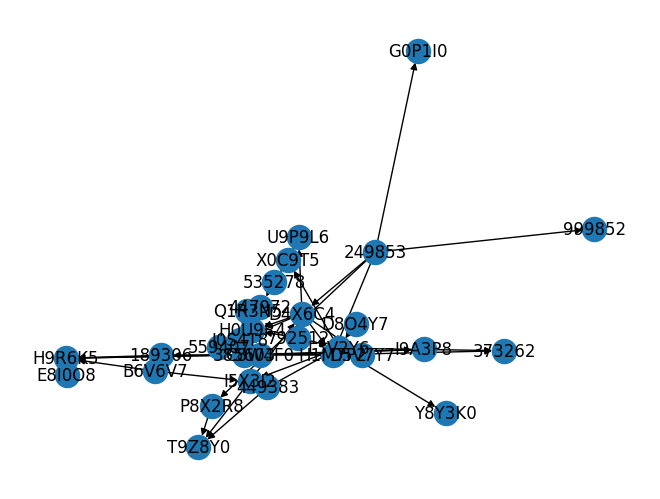

In [16]:
nx.draw(G, with_labels=True)

### 3.3 Some statistics

In [17]:
print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

Number of nodes: 30
Number of edges: 47


In [18]:
limit = 5
for index, edge in enumerate(G.edges(data=True)):
    if index == limit:
        break
    print(edge)

('B6V6V7', 'H9R6K5', {'Properties': {'source': 'signor', 'Relationship ID': nan, 'label': 'interacts_with'}})
('B6V6V7', 'I5X3I2', {'Properties': {'method': 'Lorem ipsum pblfc', 'Relationship ID': nan, 'label': 'interacts_with'}})
('H9R6K5', 'E8I0O8', {'Properties': {'Relationship ID': 'intact277910', 'label': 'interacts_with'}})
('I5X3I2', 'D4X6C4', {'Properties': {'source': 'intact', 'method': 'Lorem ipsum iiozd', 'Relationship ID': nan, 'label': 'interacts_with'}})
('I5X3I2', 'T9Z8Y0', {'Properties': {'method': 'Lorem ipsum gconp', 'Relationship ID': 'intact994853', 'label': 'interacts_with'}})


In [19]:
limit = 5
for index, node in enumerate(G.nodes(data=True)):
    if index == limit:
        break
    print(node)

('B6V6V7', {'sequence': 'CGLGLSMRFLMVGVQNWFWYGTRVPDVAYIDWHEYQHQPRVLMQNGN', 'description': 'Lorem ipsum kxujk', 'taxon': '4800', 'label': 'uniprot_isoform'})
('H9R6K5', {'sequence': 'CEDNSRWWHWPVKIAHININCSKACCENTSLATLTARSTLC', 'description': 'Lorem ipsum fdrbm', 'taxon': '7576', 'mass': 9671, 'label': 'uniprot_isoform'})
('I5X3I2', {'sequence': 'WSAAEAGGAELALDFWLVASRKKYGMLQVT', 'description': 'Lorem ipsum ddbvb', 'taxon': '4186', 'label': 'uniprot_isoform'})
('385603', {'sequence': 'EHYTERRSMRSTGQDKTSNPYLFFHITRFKRCPANQVKPWFMVLHKYEW', 'description': 'Lorem ipsum ufuuy', 'taxon': '9606', 'label': 'entrez_protein'})
('I9A3P8', {'sequence': 'YMSEGKWSIWIINMMLMHAQNLHVALIIVVY', 'description': 'Lorem ipsum dbhcg', 'taxon': '1230', 'mass': 6364, 'label': 'uniprot_protein'})
